## Centrality, Genre, Popularity

In [1]:
### Some parts of the code depend on Siqi Wu's code: https://github.com/avalanchesiqi/networked-popularity
### In order to run the code, please clone Siqi Wu's repo and put this file in the root directory.
### Remember to download all data from https://drive.google.com/drive/folders/19R3_2hRMVqlMGELZm47ruk8D9kqJvAmL?usp=sharing
### And put all data to the data folder.

### Author: Yutian Zhao
### Reference from: Siqi Wu

In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [2]:
import sys, os, platform, pickle, json, time
from datetime import datetime, timedelta
import numpy as np
from collections import Counter, defaultdict
import networkx as nx
from tqdm import tqdm
import math
import scipy as sp
import scipy.stats
from scipy.stats import pearsonr, percentileofscore
import statsmodels.api as sm

from utils.data_loader import DataLoader
from utils.plot import ColorPalette, concise_fmt, hide_spines, stackedBarPlot
data_prefix = 'data/' # ../

from powerlaw import Fit, plot_ccdf, plot_pdf

import matplotlib as mpl
if platform.system() == 'Linux':
    mpl.use('Agg')  # no UI backend

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
mpl.rcParams['lines.linewidth'] = 1

In [14]:
print("ddd: {0:.0f}".format(0.44443))

ddd: 0


In [2]:
T = 63

In [3]:
data_loader = DataLoader()
data_loader.load_embed_content_dict()
# data_loader.cwd
embed_view_dict = data_loader.embed_view_dict
embed_avg_view_dict = data_loader.embed_avg_view_dict
num_videos = data_loader.num_videos
embed_title_dict = data_loader.embed_title_dict
embed_genre_dict = data_loader.embed_genre_dict
embed_all_genre_dict = data_loader.embed_all_genre_dict

>>> Daily view data has been loaded!


In [4]:
### contrust network graph for each day
if not os.path.exists(os.path.join(data_prefix, "video_network.pkl")):
    graph_lst = []
    for i in edges:
        G = nx.DiGraph()
        G.add_edges_from(i)
        graph_lst.append(G)
        
    with open(os.path.join(data_prefix, "video_network.pkl"), 'wb') as fout:
        pickle.dump(graph_lst, fout)
else:
    with open(os.path.join(data_prefix, "video_network.pkl"), 'rb') as fin:
        graph_lst = pickle.load(fin)

In [5]:
indegree_lists = []
for i in range(T):
    indegree_list = []
    for j in range(num_videos):
        if graph_lst[i].has_node(j):
            indegree_list.append(graph_lst[i].in_degree(j))
        else:
            indegree_list.append(0)
    indegree_lists.append(indegree_list)
indegree_lists = np.array(indegree_lists)

In [6]:
min_ind = np.min(indegree_lists)
print(min_ind)
max_ind = np.max(indegree_lists)
print(max_ind)
mean_ind = np.mean(indegree_lists)
print(mean_ind)
std_ind = np.std(indegree_lists)
print(std_ind)

0
1271
5.97571668992479
21.841518504001634


In [7]:
avg_ind_list = np.mean(indegree_lists, axis=0) # in order
print(avg_ind_list.shape)
min_ind = np.min(avg_ind_list)
print(min_ind)
max_ind = np.max(avg_ind_list)
print(max_ind)
mean_ind = np.mean(avg_ind_list)
print(mean_ind)
std_ind = np.std(avg_ind_list)
print(std_ind)

(60740,)
0.0
870.6190476190476
5.97571668992479
20.828589212764456


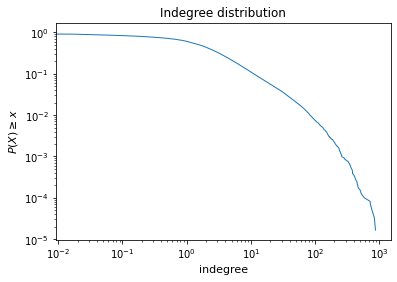

In [13]:
fig, ax1 = plt.subplots()
plot_ccdf(avg_ind_list, ax=ax1)
    
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('indegree', fontsize=11)
ax1.set_ylabel('$P(X) \geq x$', fontsize=11)
ax1.tick_params(axis='both', which='major', labelsize=10)
ax1.set_title('Indegree distribution', fontsize=12)
# ax1.legend(frameon=False, fontsize=11, ncol=1, fancybox=False, shadow=True)

plt.show()

In [10]:
# 5 min
if not os.path.exists(os.path.join(data_prefix, "cc_lists_15.pkl")):
    cc_lists = []
    for i in range(T):
        cc_list = []
        for j in range(num_videos):
            if graph_lst[i].has_node(j):
                cc_list.append(nx.clustering(graph_lst[i], j))
            else:
                cc_list.append(0)
        cc_lists.append(cc_list)
    cc_lists = np.array(cc_lists)
    with open(os.path.join(data_prefix, "cc_lists_15.pkl"), 'wb') as fout:
            pickle.dump(cc_lists, fout)
else:
    with open(os.path.join(data_prefix, "cc_lists_15.pkl"), 'rb') as fin:
        cc_lists = pickle.load(fin)
        
print(cc_lists.shape)

(63, 60740)


In [11]:
avg_cc_list = np.mean(cc_lists, axis=0) # in order
print(avg_cc_list.shape)
min_cc = np.min(avg_cc_list)
print(min_cc)
max_cc = np.max(avg_cc_list)
print(max_cc)
mean_cc = np.mean(avg_cc_list)
print(mean_cc)
std_cc = np.std(avg_cc_list)
print(std_cc)

(60740,)
0.0
0.9587301587301587
0.14656105445036346
0.10597113300461115


In [12]:
avg_num_edges = np.mean([G.number_of_edges() for G in graph_lst])
print(avg_num_edges)

362965.0317460318


In [14]:
avg_view_list = []
for i in range(num_videos):
    avg_view_list.append(embed_avg_view_dict[i])
avg_view_list = np.array(avg_view_list)
print(avg_view_list.shape)

(60740,)


In [24]:
with open(os.path.join(data_prefix, "s_avg_view_list_0.pkl"), 'rb') as fin:
        avg_view_list_0 = pickle.load(fin)

In [30]:
lscc_0 = max(nx.strongly_connected_components(graph_lst[0]), key=len)
lscc_avg_view_0 = [embed_avg_view_dict[v] for v in lscc_0]
    

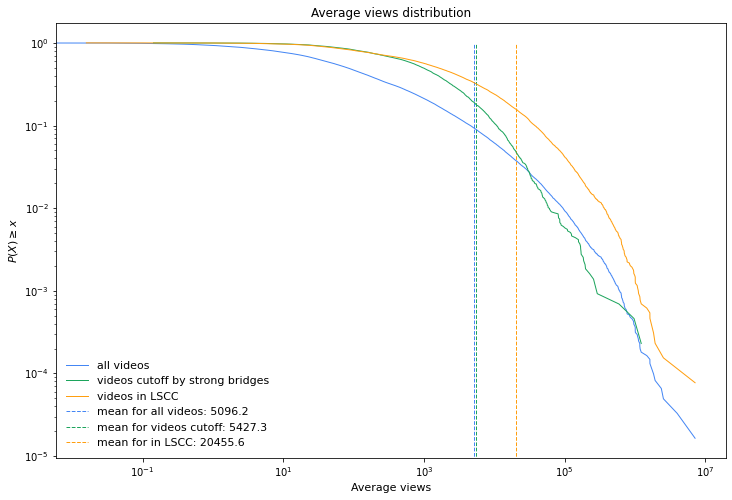

In [36]:
# usable
fig, ax1 = plt.subplots(figsize=(12,8))
plot_ccdf(avg_view_list, ax=ax1, label='all videos' ,color=ColorPalette.CC4[0])
plot_ccdf(avg_view_list_0, ax=ax1, label='videos cutoff by strong bridges',color=ColorPalette.CC4[1])
plot_ccdf(lscc_avg_view_0, ax=ax1, label='videos in LSCC', color=ColorPalette.CC4[2])

ax1.vlines(np.mean(avg_view_list), 0, 1, linestyle='dashed', color=ColorPalette.CC4[0], label='mean for all videos: {:.1f}'.format(np.mean(avg_view_list)))
ax1.vlines(np.mean(avg_view_list_0), 0, 1, linestyle='dashed',color=ColorPalette.CC4[1], label='mean for videos cutoff: {:.1f}'.format(np.mean(avg_view_list_0)))
ax1.vlines(np.mean(lscc_avg_view_0), 0, 1, linestyle='dashed', color=ColorPalette.CC4[2], label='mean for in LSCC: {:.1f}'.format(np.mean(lscc_avg_view_0)))
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('Average views', fontsize=11)
ax1.set_ylabel('$P(X) \geq x$', fontsize=11)
ax1.tick_params(axis='both', which='major', labelsize=10)
ax1.set_title('Average views distribution', fontsize=12)
ax1.legend(frameon=False, fontsize=11, ncol=1, fancybox=False, shadow=True)

plt.show()

In [14]:
print(pearsonr(avg_view_list, avg_ind_list))
print(pearsonr(avg_view_list, avg_cc_list))
print(pearsonr(avg_ind_list, avg_cc_list))

(0.535981654161106, 0.0)
(-0.09486011659291047, 2.06011975451955e-121)
(-0.17915160526862905, 0.0)


In [81]:
ind_cc = np.stack((avg_ind_list, avg_cc_list), axis=-1)
ind_cc_X = sm.add_constant(ind_cc)
model = sm.OLS(avg_view_list,ind_cc_X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.287
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                 1.224e+04
Date:                Wed, 26 May 2021   Prob (F-statistic):               0.00
Time:                        20:19:45   Log-Likelihood:            -7.3591e+05
No. Observations:               60740   AIC:                         1.472e+06
Df Residuals:                   60737   BIC:                         1.472e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3047.4481    321.338     -9.484      0.000   -3677.272   -2417.624
x1          1348.2420      8.755    153.995      0.000    1331.082    1365.402
x2           593.2478   1720.811      0.345      0.730   -2779.547    3966.043
==============================================================================
Omnibus:                   208207.474   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     125245074090.381
Skew:                          63.673   Prob(JB):                         0.00
Kurtosis:                    7036.595   Cond. No.                         210.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [75]:
np.stack?

In [15]:
vid_by_genres = defaultdict(list)

In [16]:
for i in range(num_videos):
    if len(embed_genre_dict[i]) == 0:
        vid_by_genres["NoInfo"].append(i)
    else:
        for j in embed_genre_dict[i]:
            vid_by_genres[j].append(i)
print([(k, len(v)) for k, v in vid_by_genres.items()])

[('Hip_hop_music', 10850), ('Pop_music', 22587), ('Soul_music', 4341), ('Rock_music', 14662), ('Independent_music', 7250), ('Country_music', 4398), ('Electronic_music', 4461), ('NoInfo', 7582)]


In [27]:
topics = ['Pop_music', 'Rock_music', 'Hip_hop_music', 'Independent_music',
                    'Country_music', 'Electronic_music', 'Soul_music', 'Others']
avg_view_topic = []
avg_cc_topic = []
avg_ind_topic = []
for i in topics:
    avg_view_topic.append(np.mean(avg_view_list[vid_by_genres[i]]))
    avg_cc_topic.append(np.mean(avg_cc_list[vid_by_genres[i]]))
    avg_ind_topic.append(np.mean(avg_ind_list[vid_by_genres[i]]))


<BarContainer object of 8 artists>

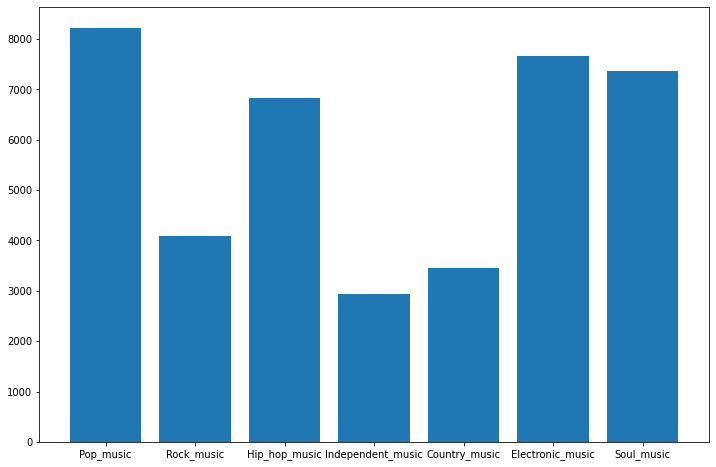

In [24]:
plt.figure(figsize=(12, 8))
plt.bar(topics, avg_view_topic)

<BarContainer object of 8 artists>

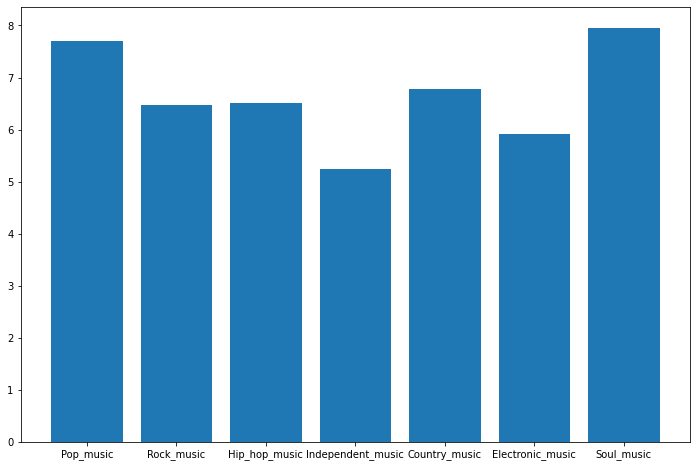

In [28]:
plt.figure(figsize=(12, 8))
plt.bar(topics, avg_ind_topic)

<BarContainer object of 8 artists>

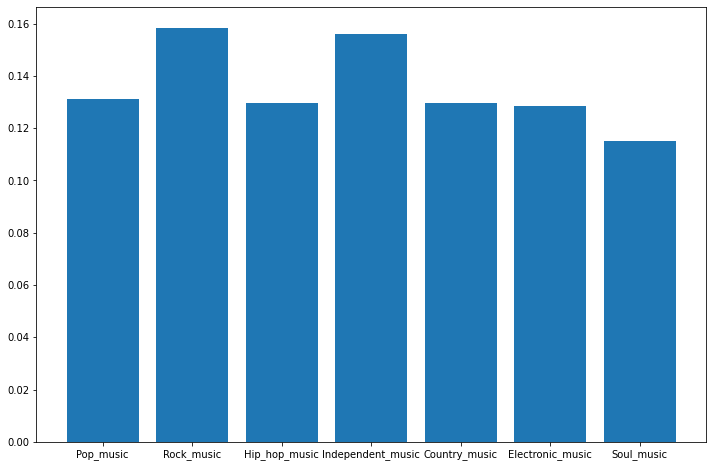

In [29]:
plt.figure(figsize=(12, 8))
plt.bar(topics, avg_cc_topic)

In [59]:
all_topics = []
for i in embed_all_genre_dict.values():
    for j in i:
        if j not in all_topics:
            all_topics.append(j)
print(all_topics)
for i in ['Television_program', 'Military', 'Entertainment', 'Performing_arts', 'Film','Music_of_Asia', 'Music_of_Latin_America']:
    all_topics.remove(i)
print(all_topics)

['Pop_music', 'Electronic_music', 'Rhythm_and_blues', 'Country_music', 'Soul_music', 'Reggae', 'Independent_music', 'Rock_music', 'Hip_hop_music', 'Music_of_Latin_America', 'Military', 'Jazz', 'Television_program', 'Christian_music', 'Music_of_Asia', 'Classical_music', 'Entertainment', 'Performing_arts', 'Film']
['Pop_music', 'Electronic_music', 'Rhythm_and_blues', 'Country_music', 'Soul_music', 'Reggae', 'Independent_music', 'Rock_music', 'Hip_hop_music', 'Jazz', 'Christian_music', 'Classical_music']


In [32]:
vid_by_all_genres = defaultdict(list)
for i in range(num_videos):
    if len(embed_all_genre_dict[i]) == 0:
        vid_by_all_genres["NoInfo"].append(i)
    else:
        for j in embed_all_genre_dict[i]:
            vid_by_all_genres[j].append(i)
print([(k, len(v)) for k, v in vid_by_all_genres.items()])

[('Hip_hop_music', 10850), ('Pop_music', 22587), ('Rhythm_and_blues', 3926), ('Soul_music', 4341), ('Rock_music', 14662), ('Independent_music', 7250), ('Country_music', 4398), ('Electronic_music', 4461), ('NoInfo', 4357), ('Christian_music', 2866), ('Reggae', 362), ('Jazz', 878), ('Music_of_Latin_America', 366), ('Classical_music', 272), ('Television_program', 152), ('Military', 31), ('Entertainment', 4), ('Performing_arts', 2), ('Music_of_Asia', 21), ('Film', 1)]


In [60]:
avg_view_topic = []
avg_cc_topic = []
avg_ind_topic = []
for i in all_topics:
    avg_view_topic.append(np.mean(avg_view_list[vid_by_all_genres[i]]))
    avg_cc_topic.append(np.mean(avg_cc_list[vid_by_all_genres[i]]))
    avg_ind_topic.append(np.mean(avg_ind_list[vid_by_all_genres[i]]))
avg_view_topic = np.array(avg_view_topic)
avg_ind_topic = np.array(avg_ind_topic)
avg_cc_topic = np.array(avg_cc_topic)


Text(0.5, 0, 'Average views')

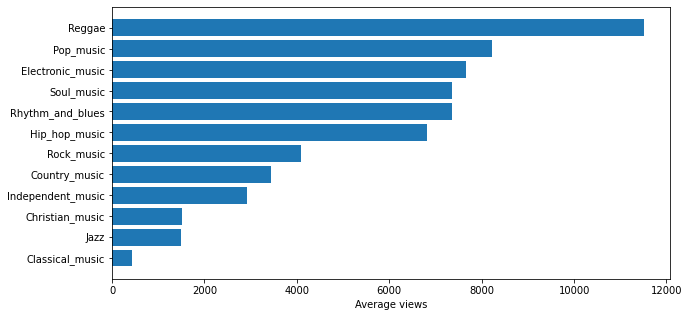

In [83]:
plt.figure(figsize=(10, 5))
all_topics = np.array(all_topics)
ind_sort = np.argsort(avg_view_topic)
avg_view_topic_sorted = avg_view_topic[ind_sort]
all_topics_sorted = all_topics[ind_sort]
plt.barh(all_topics_sorted, avg_view_topic_sorted)
plt.xlabel("Average views")

In [62]:
all_topics_sorted

array(['Classical_music', 'Jazz', 'Christian_music', 'Independent_music',
       'Country_music', 'Rock_music', 'Hip_hop_music', 'Rhythm_and_blues',
       'Soul_music', 'Electronic_music', 'Pop_music', 'Reggae'],
      dtype='<U17')

In [68]:
mainstream = set()
niche = set()
for i in ['Hip_hop_music', 'Rhythm_and_blues', 'Soul_music', 'Electronic_music', 'Pop_music', 'Reggae']:
    mainstream = mainstream.union(set(vid_by_all_genres[i]))
for i in ['Classical_music', 'Jazz', 'Christian_music', 'Independent_music', 'Country_music', 'Rock_music']:
    niche = niche.union(set(vid_by_all_genres[i]))


In [69]:
print(len(mainstream))
print(len(niche))

35615
26844


In [70]:
avg_view_p = []
avg_cc_p = []
avg_ind_p = []
for i in [mainstream, niche]:
    avg_view_p.append(np.mean(avg_view_list[list(i)]))
    avg_cc_p.append(np.mean(avg_cc_list[list(i)]))
    avg_ind_p.append(np.mean(avg_ind_list[list(i)]))
print(avg_view_p, avg_cc_p, avg_ind_p)

[7047.293781601742, 3252.6267422828664] [0.13358531593227815, 0.15685447655322599] [6.785070941662266, 5.946998294673753]


In [93]:
scipy.stats.ttest_ind(avg_view_list[list(mainstream)],avg_view_list[list(niche)])

Ttest_indResult(statistic=9.451480232320236, pvalue=3.451503860150913e-21)

In [91]:
scipy.stats.ttest_ind(avg_ind_list[list(mainstream)],avg_ind_list[list(niche)])

Ttest_indResult(statistic=4.720833678126951, pvalue=2.3538855465617835e-06)

In [92]:
scipy.stats.ttest_ind(avg_cc_list[list(mainstream)],avg_cc_list[list(niche)])

Ttest_indResult(statistic=-28.17656121131, pvalue=1.3916341706698769e-173)

In [94]:
len(mainstream.intersection(niche))

6197

In [96]:
def in_one(vid):
    if vid in niche:
        return 1
    else:
        return 0
niche_indicators= [in_one(i) for i in range(num_videos)]
ind_cc_n = np.stack((avg_ind_list, avg_cc_list, niche_indicators), axis=-1)
print(ind_cc_n.shape)
ind_cc_n_X = sm.add_constant(ind_cc_n)
model = sm.OLS(avg_view_list,ind_cc_n_X)
results = model.fit()
results.summary()

(60740, 3)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                     8198.
Date:                Wed, 26 May 2021   Prob (F-statistic):               0.00
Time:                        20:55:50   Log-Likelihood:            -7.3587e+05
No. Observations:               60740   AIC:                         1.472e+06
Df Residuals:                   60736   BIC:                         1.472e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1809.0965    349.220     -5.180      0.000   -2493.569   -1124.624
x1          1349.3908      8.750    154.212      0.000    1332.240    1366.541
x2          1958.4780   1726.315      1.134      0.257   -1425.105    5342.061
x3         -3270.2973    362.411     -9.024      0.000   -3980.624   -2559.971
==============================================================================
Omnibus:                   208257.508   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     125531292065.944
Skew:                          63.718   Prob(JB):                         0.00
Kurtosis:                    7044.629   Cond. No.                         211.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [97]:
niche_indicators= [in_one(i) for i in range(num_videos)]
# ind_cc_n = np.stack((avg_ind_list, avg_cc_list, niche_indicators), axis=-1)
print(ind_cc_n.shape)
n_X = sm.add_constant(niche_indicators)
model = sm.OLS(avg_view_list,n_X)
results = model.fit()
results.summary()

(60740, 3)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     59.66
Date:                Wed, 26 May 2021   Prob (F-statistic):           1.14e-14
Time:                        20:57:09   Log-Likelihood:            -7.4617e+05
No. Observations:               60740   AIC:                         1.492e+06
Df Residuals:                   60738   BIC:                         1.492e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6556.2416    284.330     23.059      0.000    5998.953    7113.530
x1         -3303.6149    427.698     -7.724      0.000   -4141.904   -2465.326
==============================================================================
Omnibus:                   205399.398   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     112429098106.445
Skew:                          61.166   Prob(JB):                         0.00
Kurtosis:                    6666.991   Cond. No.                         2.50
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [40]:
embed_ratio_dict = {}
embed_predict_dict = {}
embed_incoming_dict = {}
embed_weight_dict = {}
with open(os.path.join('models', 'forecast_tracker_all.json'), 'r') as fin:
    for line in fin:
        result_json = json.loads(line.rstrip())
        tar_embed = result_json['embed']
        embed_predict_dict[tar_embed] = result_json['arnet_pred']
        embed_incoming_dict[tar_embed] = result_json["incoming_embeds"]
        embed_weight_dict[tar_embed] = result_json["link_weights"]
        net_ratio = result_json['net_ratio']
        embed_ratio_dict[tar_embed] = net_ratio

print(len(embed_ratio_dict.keys()))

13710


In [41]:
 embed_predict_dict[10]* embed_weight_dict[10][0]

TypeError: can't multiply sequence by non-int of type 'float'

In [57]:
def check_ratio(emb):
    print(embed_ratio_dict[emb])
    s = np.sum(embed_predict_dict[emb])
    ss = np.zeros(len(embed_predict_dict[emb]))
    for ind, i in enumerate(embed_incoming_dict[emb]):
        ss += np.array(embed_view_dict[i][-7:])*embed_weight_dict[emb][ind]

    sss = np.sum(ss)
    print(sss/s)
    return sss/s == embed_ratio_dict[emb]

In [58]:
check_ratio(8)

0.15319451761611655
0.11231772014677115


False

In [113]:
m_count = 0
n_count = 0
m_ratios = []
n_ratios = []
m_avg_view = 0
n_avg_view = 0
m_avg_view_no_network = 0
n_avg_view_no_network = 0
for i in embed_ratio_dict.keys():
    if i in mainstream:
        m_count+=1
        m_ratios.append(embed_ratio_dict[i])
        m_avg_view += embed_avg_view_dict[i]
        m_avg_view_no_network += embed_avg_view_dict[i]*(1-embed_ratio_dict[i])
    if i in niche:
        n_count+=1
        n_ratios.append(embed_ratio_dict[i])
        n_avg_view += embed_avg_view_dict[i]
        n_avg_view_no_network += embed_avg_view_dict[i]*(1-embed_ratio_dict[i])
m_avg_view_no_network /= m_count
n_avg_view_no_network /= n_count
m_avg_view /= m_count
n_avg_view /= n_count
m_ratios_mean = np.mean(m_ratios)
n_ratios_mean = np.mean(n_ratios)
print(m_ratios_mean, n_ratios_mean)
print(m_avg_view, n_avg_view)
print((m_avg_view-m_avg_view_no_network)/m_avg_view_no_network, (n_avg_view-n_avg_view_no_network)/n_avg_view_no_network)

0.29399922069344625 0.33108904834451364
24527.151819696566 10267.965118331309
0.47602785694032834 0.4654611585279098


Text(0.5, 1.0, 'network contribution for mainstream and niche')

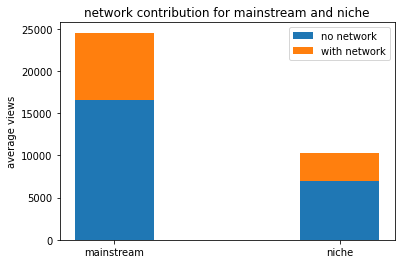

In [116]:
plt.bar(['mainstream', 'niche'], [m_avg_view_no_network, n_avg_view_no_network], width = 0.35, label='no network')
plt.bar(['mainstream', 'niche'], [m_avg_view-m_avg_view_no_network, n_avg_view-n_avg_view_no_network], bottom=[m_avg_view_no_network, n_avg_view_no_network], width = 0.35, label='with network')
plt.legend()
plt.ylabel("average views")
plt.title("network contribution for mainstream and niche")

NameError: name 'tomato' is not defined

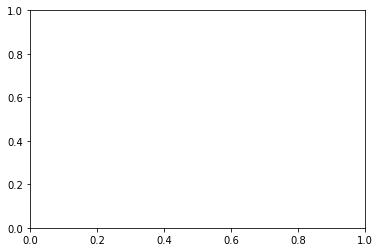

In [119]:
persistent_vids = list(embed_ratio_dict.keys())
n_vids = []
m_vids = []
n_no_network = []
n_with_network = []
m_no_network = []
m_with_network = []
mn_no_network = []
mn_with_network = []
for i in persistent_vids:
    mn_no_network.append(embed_avg_view_dict[i]*(1-embed_ratio_dict[i]))
    mn_with_network.append(embed_avg_view_dict[i])
    if i in mainstream:
        m_vids.append(i)
        m_with_network.append(embed_avg_view_dict[i])
        m_no_network.append(embed_avg_view_dict[i]*(1-embed_ratio_dict[i]))
    if i in niche:
        n_vids.append(i)
        n_with_network.append(embed_avg_view_dict[i])
        n_no_network.append(embed_avg_view_dict[i]*(1-embed_ratio_dict[i]))

n_no_network_perc = [percentileofscore(mn_no_network, i) for i in n_no_network]
n_with_network_perc = [percentileofscore(mn_with_network, i) for i in n_with_network]
m_no_network_perc = [percentileofscore(mn_no_network, i) for i in m_no_network]
m_with_network_perc = [percentileofscore(mn_with_network, i) for i in m_with_network]

n_percentile_mat = [[] for _ in range(10)]
n_vid_mat = [[] for _ in range(10)]
for idx, percentile_value in enumerate(n_no_network_perc):
    bin_idx = min(int(np.floor(percentile_value / 10)), 9)
    n_percentile_mat[bin_idx].append(n_with_network_perc[idx] - percentile_value)
    n_vid_mat[bin_idx].append(n_vids[idx])



Text(0.5, 1.0, 'percentile change of niche videos')

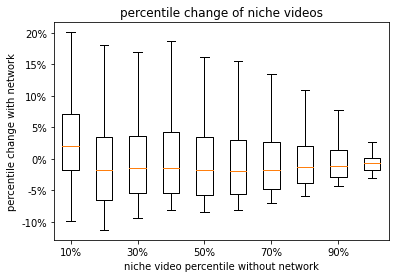

In [124]:
fig, ax = plt.subplots()
# red_circle = dict(markerfacecolor=tomato, marker='o', markersize=4)
n_boxplot = ax.boxplot(n_percentile_mat, showfliers=False, widths=0.5)
# ax.axhline(y=0, color=cornflower_blue, linestyle='--', lw=1, zorder=0)
ax.set_xlabel('niche video percentile without network')
ax.set_ylabel('percentile change with network')
# ax.tick_params(**tick_style)
ax.set_xticks(ax.get_xticks()[::2])
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{0:.0f}%'.format(10 * x)))
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{0:.0f}%'.format(x)))
ax.set_title('percentile change of niche videos (outliers hidden)')

Text(0.5, 1.0, 'percentile change of mainstream videos (outliers hidden)')

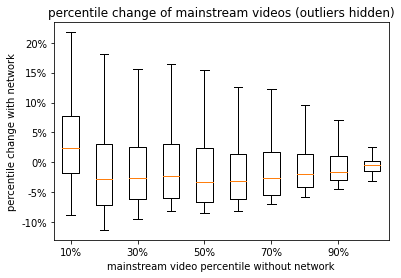

In [126]:
m_percentile_mat = [[] for _ in range(10)]
m_vid_mat = [[] for _ in range(10)]
for idx, percentile_value in enumerate(m_no_network_perc):
    bin_idx = min(int(np.floor(percentile_value / 10)), 9)
    m_percentile_mat[bin_idx].append(m_with_network_perc[idx] - percentile_value)
    m_vid_mat[bin_idx].append(m_vids[idx])
    
fig, ax = plt.subplots()
# red_circle = dict(markerfacecolor=tomato, marker='o', markersize=4)
ax.boxplot(m_percentile_mat, showfliers=False, widths=0.5)
# ax.axhline(y=0, color=cornflower_blue, linestyle='--', lw=1, zorder=0)
ax.set_xlabel('mainstream video percentile without network')
ax.set_ylabel('percentile change with network')
# ax.tick_params(**tick_style)
ax.set_xticks(ax.get_xticks()[::2])
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{0:.0f}%'.format(10 * x)))
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{0:.0f}%'.format(x)))
ax.set_title('percentile change of mainstream videos (outliers hidden)')

No handles with labels found to put in legend.


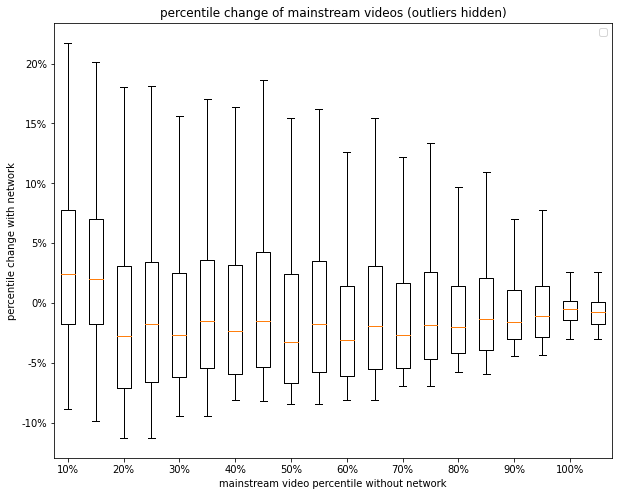

In [139]:
mn_percentile_mat = [[] for _ in range(20)]
mn_percentile_mat_labels = ["" for _ in range(20)]
for i in range(20):
    if i%2==0:
        mn_percentile_mat[i]=m_percentile_mat[int(i/2)]
        mn_percentile_mat_labels[i] = 'mainstream'
    else:
        mn_percentile_mat[i]=n_percentile_mat[math.floor(i/2)]
        mn_percentile_mat_labels[i] = 'niche'
        
fig, ax = plt.subplots(figsize=(10,8))        
ax.boxplot(mn_percentile_mat, showfliers=False, widths=0.5, labels=mn_percentile_mat_labels)
ax.set_xlabel('mainstream video percentile without network')
ax.set_ylabel('percentile change with network')
# ax.tick_params(**tick_style)
ax.set_xticks(ax.get_xticks()[::2])
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{0:.0f}%'.format(10 * math.ceil(x/2))))
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{0:.0f}%'.format(x)))
ax.set_title('percentile change of mainstream videos (outliers hidden)')

In [131]:
math.ceil(3/2)

2

In [146]:
def find_outliers(percentile_mat, vid_mat, whis=1.5,):   
    top_outliers_list = []
    bottom_outliers_list = []
    for box_idx, box in enumerate(percentile_mat):
        q1 = np.percentile(box, 25)
        q3 = np.percentile(box, 75)
        iq = q3 - q1
        hi_val = q3 + whis * iq
        lo_val = q1 - whis * iq
        for idx, val in enumerate(box):
            if val > hi_val:
                top_outliers_list.append(vid_mat[box_idx][idx]) # (artist_cid_mat[box_idx][idx], val
            elif val < lo_val:
                bottom_outliers_list.append(vid_mat[box_idx][idx])
        return top_outliers_list, bottom_outliers_list
# same genre, denser, higher werghts 
n_top_outliers_list, n_bottom_outliers_list = find_outliers(n_percentile_mat, n_vid_mat) 
m_top_outliers_list, m_bottom_outliers_list = find_outliers(m_percentile_mat, m_vid_mat) 
print(n_top_outliers_list, m_top_outliers_list)

[5333, 5487, 14328, 16552, 18134, 19805, 23158, 23380, 24022, 24246, 24892, 28875, 29661, 31564, 32107, 35755, 39198, 42706, 43343, 43888, 44890, 57303, 59509] [211, 6200, 6824, 8303, 11994, 13582, 18134, 19805, 23158, 23693, 29045, 31615, 31874, 37069, 40150, 43888, 44890, 49977, 50108, 53096, 56420, 58915, 59459]


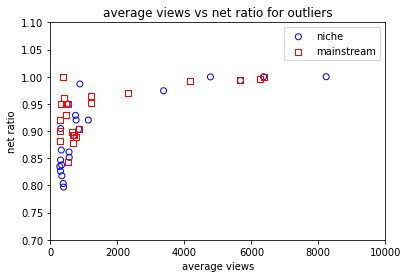

In [170]:
n_outliers_ratio_list = [embed_ratio_dict[i] for i in n_top_outliers_list]
n_outliers_avg_view_list = [embed_avg_view_dict[i] for i in n_top_outliers_list]
m_outliers_ratio_list = [embed_ratio_dict[i] for i in m_top_outliers_list]
m_outliers_avg_view_list = [embed_avg_view_dict[i] for i in m_top_outliers_list]
plt.scatter(n_outliers_avg_view_list, n_outliers_ratio_list, facecolors='none', marker='o', color='b', label='niche')
plt.scatter(m_outliers_avg_view_list, m_outliers_ratio_list, facecolors='none', marker='s', color='r', label='mainstream')
plt.ylim(0.7, 1.1)
plt.xlim(0, 10000)
plt.xlabel('average views')
plt.ylabel('net ratio')
plt.legend()
# plt.xscale('log')
plt.title("average views vs net ratio for outliers")
plt.show()

In [171]:
m_example_outliers = [embed_title_dict[i] for i in m_top_outliers_list if embed_avg_view_dict[i]>2000]
n_example_outliers = [embed_title_dict[i] for i in n_top_outliers_list if embed_avg_view_dict[i]>2000]
print(m_example_outliers)
print(n_example_outliers)

['Mindless Behavior - Hello', 'The Style Council - Shout To The Top', 'R. Kelly - Trapped in the Closet Chapter 12', 'Ellie Goulding - Guns And Horses', "Lauren Daigle - Here's My Heart (Audio)"]
['Chris Stapleton - When The Stars Come Out (Audio)', "Kacey Musgraves - Merry Go 'Round", 'Ellie Goulding - Guns And Horses', 'Breaking Benjamin - Down (Audio)', "Lauren Daigle - Here's My Heart (Audio)"]
